In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(451)

from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


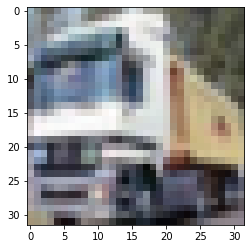

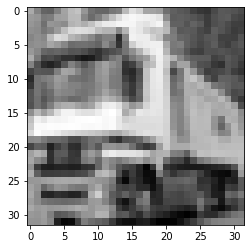

In [3]:
#gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
x_train_gray = np.dot(x_train[:,:,:,:3], [0.299, 0.587, 0.114])
x_test_gray = np.dot(x_test[:,:,:,:3], [0.299, 0.587, 0.114])

x_train_gray = x_train_gray.reshape(-1,32,32,1)
x_test_gray = x_test_gray.reshape(-1,32,32,1)

from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

plt.imshow(x_train[1])
plt.show()

plt.imshow(x_train_gray[1,:,:,0], cmap='gray')
plt.show()

In [4]:
np.random.seed(451)

import datetime

from keras.layers import Flatten, Activation, Conv2D, MaxPool2D, AvgPool2D, Dense, Dropout, BatchNormalization, Input, MaxPooling2D, Flatten, Activation, Conv2D, AvgPool2D, Dense, Dropout, concatenate, AveragePooling2D
from keras.optimizers import Adam, SGD
from keras.models import Sequential
import keras.backend as K
from keras.regularizers import l1,l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.models import model_from_json, Model

def build_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, (1,1), padding='same', activation='relu', 
                     kernel_regularizer=regularization, name='tower_%d_%dx%da'%(tower_nr, shape[0], shape[1]))(input_layer)
    tower = Conv2D(features_nr*2, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, name='tower_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(tower)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                dropout=False, normalization=False, regularization="l2", dropout_ratio=0.25):
    #3x3 kernel tower
    tower = Conv2D(features_nr, shape, padding='same', activation='relu',
                     kernel_regularizer=regularization, 
                   name='tower_simple_%d_%dx%db'%(tower_nr, shape[0], shape[1]))(input_layer)
    #condidional dropout/normalization
    if dropout:
        tower = Dropout(dropout_ratio, name='tower_%d_%dx%ddrop'%(tower_nr, shape[0], shape[1]))(tower)
    if normalization:
        tower = BatchNormalization(name='tower_%d_%dx%dnorm'%(tower_nr, shape[0], shape[1]))(tower)
        
    return tower

def build_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_simple_tower_subsample(input_layer, features_nr, shape, tower_nr, 
                          dropout=False, normalization=False, regularization='l2', dropout_ratio=0.25):
    tower = build_simple_tower(input_layer, features_nr, shape, tower_nr, 
                        dropout, normalization, regularization, dropout_ratio)
    pool = MaxPooling2D((2,2), padding='same', name='tower_%d_2x2subsample'%(tower_nr))(tower)

    return pool

def build_dense(input_layer, neurons_nr, dense_nr, 
                dropout=False, normalization=False, regularization='l2', dropout_ratio=0.5):
    dense = Dense(neurons_nr, kernel_regularizer=regularization, 
                  name='dense_%d_%d'%(dense_nr, neurons_nr))(input_layer)
    
    if dropout:
        dense = Dropout(dropout_ratio, name='dense_%d_%ddrop'%(dense_nr, neurons_nr))(dense)
    if normalization:
        dense = BatchNormalization(name='dense_%d_%dnorm'%(dense_nr, neurons_nr))(dense)
    
    return dense

def build_inception_module(input_layer, features_nr, module_nr, 
                           dropout=False, normalization=False, regularization='l2', dropout_ratio=0.2):  
    #feature_nr is an array we'll use to build our layers
    #data is in the form: [1x1, 3x3 reduce, 3x3, 5x5 reduce, 5x5, pool proj]
  
    inception_1x1 = Conv2D(features_nr[0],1,1,border_mode='same',activation='relu',name='inception_%d_/1x1'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3_reduce = Conv2D(features_nr[1],1,1,border_mode='same',activation='relu',name='inception_%d_/3x3_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_3x3 = Conv2D(features_nr[2],3,3,border_mode='same',activation='relu',name='inception_%d_/3x3'%(module_nr),W_regularizer=l2(0.0002))(inception_3x3_reduce)
    
    inception_5x5_reduce = Conv2D(features_nr[3],1,1,border_mode='same',activation='relu',name='inception_%d_/5x5_reduce'%(module_nr),W_regularizer=l2(0.0002))(input_layer)
    
    inception_5x5 = Conv2D(features_nr[4],5,5,border_mode='same',activation='relu',name='inception_%d_/5x5'%(module_nr),W_regularizer=l2(0.0002))(inception_5x5_reduce)
    
    inception_pool = MaxPooling2D(pool_size=(3,3),strides=(1,1),border_mode='same',name='inception_%d_/pool'%(module_nr))(input_layer)
    
    inception_pool_proj = Conv2D(features_nr[5],1,1,border_mode='same',activation='relu',name='inception_%d_/pool_proj'%(module_nr),W_regularizer=l2(0.0002))(inception_pool)
    
    inception_output = concatenate([inception_1x1,inception_3x3,inception_5x5,inception_pool_proj],axis=3,name='inception_%d_/output'%(module_nr))

    if dropout:
        inception_output = Dropout(dropout_ratio, name='inception_%d_/output_drop'%(module_nr))(inception_output)
    if normalization:
        inception_output = BatchNormalization(name='inception_%d_/output_norm'%(module_nr))(inception_output)

    pooled = MaxPooling2D((2,2), padding='same', name='inception_%d_2x2subsample'%(module_nr))(inception_output)
    
    return pooled

i='cifar10-nrcrt7-'+datetime.datetime.now().strftime("%I:%M%p_%B-%d-%Y")

K.clear_session()

!mkdir -p models
!mkdir -p logs

a = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')#will stop the model if val_loss does not improve for 2 consecutive epochs
b = ModelCheckpoint(monitor='val_loss', filepath='./models/'+str(i)+'.hdf5', verbose=1, save_best_only=True)#save model weights after each epoch if val_loss improves
c = TensorBoard(log_dir='./logs/'+str(i),
                write_grads=True,
                write_graph=True,
                write_images=True,
                batch_size=128)#saves a log file for tensorboard; remember to save different runs to different subdirectories

#we'll use this instead of decay
d = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

callbacks=[a,b,c,d]

#------------model definition-------------------

use_norm = True
lrate = 0.001

input_img = Input(shape = (32, 32, 3), name='input')

#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
               # kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

#hopefully this will learn a good internal representation of the image channels
#conv_1 = Conv2D(1, (1,1), padding='same', activation='relu', 
                #kernel_regularizer = regularization, name='conv_64x64x1_inception_in')(input_img)

inception_1 = build_inception_module(input_img, [64,96,128,16,32,32], 1, False, use_norm)

inception_2 = build_inception_module(inception_1, [128,128,192,32,96,64], 2, False, use_norm)

inception_3 = build_inception_module(inception_2, [192,96,208,16,48,64], 3, False, use_norm)

inception_4 = build_inception_module(inception_3, [160, 112, 224, 24, 64, 64], 4, False, use_norm)
#tower_3 = build_simple_tower(inception_2, 144, (3,3),  3, False, use_norm)
#tower_4 = build_simple_tower_subsample(tower_3, 144, (3,3), 4, False, use_norm)

#tower_5 = build_simple_tower(tower_4, 288, (3,3),  5, False, use_norm)
#tower_6 = build_simple_tower_subsample(tower_5, 288, (3,3), 6, False, use_norm)

#model top

flat_pool = AveragePooling2D(pool_size=(2, 2), padding='valid')(inception_4)

flat = Flatten()(flat_pool)


dense_5 = build_dense(flat, 128, 1, True, use_norm)

dense_6 = build_dense(dense_5, 64, 2, True, use_norm)

out = Dense(10, activation='softmax')(dense_6)

model = Model(inputs = input_img, outputs = out)

#-----------------------------------------------

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lrate),
              metrics=['accuracy'])

model.summary()

model_json = model.to_json()
with open("./models/"+str(i)+".json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to" + "../models/"+str(i)+".json")


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", name="inception_1_/1x1", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (1, 1), activation="relu", name="inception_1_/3x3_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="inception_1_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (1, 1), activation="relu", name="inception_1_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(224, (3, 3), activation="relu", name="inception_4_/3x3", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), activation="relu", name="inception_4_/5x5_reduce", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", name="inception_4_/5x5", padding="same", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:85: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 3), strides=(1, 1), name="inception_4_/pool", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launc

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
inception_1_/3x3_reduce (Conv2D (None, 32, 32, 96)   384         input[0][0]                      
__________________________________________________________________________________________________
inception_1_/5x5_reduce (Conv2D (None, 32, 32, 16)   64          input[0][0]                      
__________________________________________________________________________________________________
inception_1_/pool (MaxPooling2D (None, 32, 32, 3)    0           input[0][0]                      
____________________________________________________________________________________________

In [5]:
import tensorflow as tf

with tf.device('/gpu:0'):
  model.fit(x_train, y_train_cat, batch_size=128, epochs=100, validation_split=0.2,verbose=1,callbacks=callbacks)  # starts training

result = model.evaluate(x_test, y_test_cat)

print("Accuracy on test set: ",result[1]*100,"%")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 40000 samples, validate on 10000 samples


Epoch 1/100
40000/40000 [==============================] - 82s 2ms/step - loss: 0.9786 - accuracy: 0.9078 - val_loss: 0.5475 - val_accuracy: 0.9000

Epoch 00001: val_loss improved from inf to 0.54750, saving model to ./models/cifar10-nrcrt7-04:40PM_May-08-2020.hdf5

Epoch 2/100
40000/40000 [==============================] - 72s 2ms/step - loss: 0.3377 - accuracy: 0.9300 - val_loss: 0.3393 - val_accuracy: 0.9153

Epoch 00002: val_loss improved from 0.54750 to 0.33929, saving model to ./models/cifar10-nrcrt7-04:40PM_May-08-2020.hdf5
Epoch 3/100
40000/40000 [==============================] - 72s 2ms/step - loss: 0.2591 - accuracy: 0.9399 - val_loss: 0.3167 - val_accuracy: 0.9171

Epoch 00003: val_loss improved from 0.33929 to 0.31674, saving model to ./models/cifar10-nrcrt7-04:40PM_May-08-2020.hdf5
Epoch 4/100
40000/40000 [=====================

In [9]:
predict = model.predict(x_test)
m = max(predict[7])
index = [i for i,j in enumerate(predict[7]) if j == m]
print("The value of the prediction of test sample with index 7 is :")
print(index)

The value of the prediction of test sample with index 7 is :
[6]


The actual class of test sample with index 7 is: 


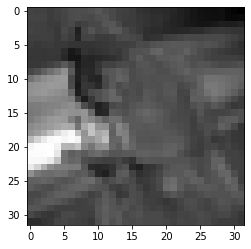

In [10]:
print("The actual class of test sample with index 7 is: ")
plt.imshow(x_test[7,:,:,0], cmap='gray')
plt.show()

In [11]:
model.load_weights('./models/cifar10-nrcrt7-04:40PM_May-08-2020.hdf5')

result = model.evaluate(x_test, y_test_cat)

print(result)

10000/10000 [==============================] - 8s 794us/step
[0.13478883649110793, 0.9691197276115417]
